In [1]:
import broadbean as bb
from broadbean.plotting import plotter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (8, 3)
mpl.rcParams['figure.subplot.bottom'] = 0.15 

from hatdrivers.Hat_AWG5014C import Hat_AWG5014C
from qcodes.instrument_drivers.tektronix.AWG5014 import Tektronix_AWG5014
awg = Tektronix_AWG5014('AWG2', 'TCPIP0::169.254.116.102::inst0::INSTR', timeout=40)
#%%SignalCores
from hatdrivers.SignalCore_sc5511a import SignalCore_SC5511A
dll_path = r'C:\Users\Hatlab_3\Desktop\RK_Scripts\New_Drivers\HatDrivers\DLL\sc5511a.dll'
SC5 = SignalCore_SC5511A('SigCore5', serial_number = '10001851', debug = True)
SC9 = SignalCore_SC5511A('SigCore9', serial_number = '1000190E', debug = True)

Connected to: TEKTRONIX AWG5014C (serial:B050109, firmware:SCPI:99.0 FW:4.6.0.7) in 0.24s
<CDLL 'c:\users\hatlab_3\desktop\rk_scripts\new_drivers\hatdrivers\hatdrivers\DLL//sc5511a.dll', handle 7ffdc3b70000 at 0x25981df3d48>
10001851 c_void_p(2585551853728)
check status 1
<CDLL 'c:\users\hatlab_3\desktop\rk_scripts\new_drivers\hatdrivers\hatdrivers\DLL//sc5511a.dll', handle 7ffdc3b70000 at 0x25981e0de48>
1000190E c_void_p(2585551853984)
check status 1


In [62]:
#inputs from other scripts, i.e. things you need to know before this: 
LO_frequency = 6168000000.0+1e6
DC_offsets = (-0.079, -0.12, 0.0, 0.0)
ch2_correction = 0.9971025937916236 #voltage correction ratio
phase_offset = 0.040878106083876986 #radians

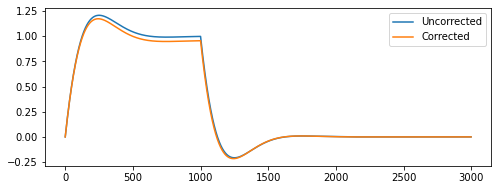

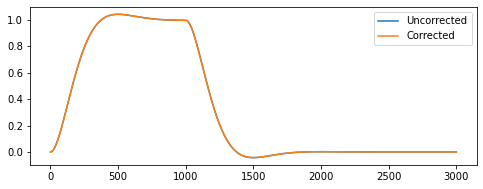

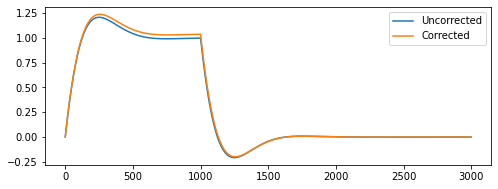

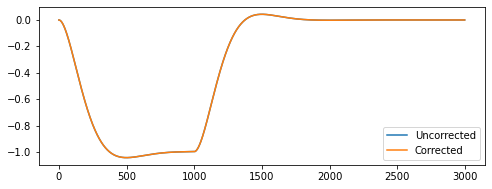

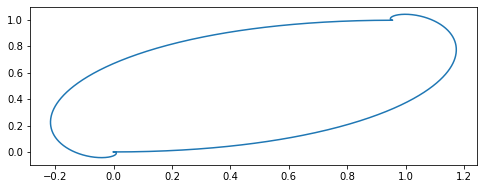

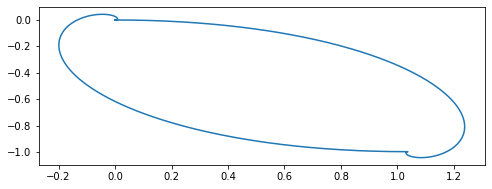

In [63]:
#%%
#practicing modulation
sim_filepath1 = r'H:\RK\Transfer\kappa_2MHz_Chi_2MHz_-det_plus_ringdown.csv'
sim_filepath2 = r'H:\RK\Transfer\kappa_2MHz_Chi_2MHz_+det_plus_ringdown.csv'

def phase_shifter(I_data, Q_data, phase_offset, plot = False): 
    '''
    This will take I as the perfect channel and some phase offset sin(theta_imbalance) offsetting Q towards I
    Assuming I to be the unit magnitude
    '''
    
    Q_res = Q_data
    I_res = (I_data-np.sin(phase_offset)*Q_data)/np.cos(phase_offset)
    if plot: 
        plt.figure()
        plt.title("Before phase correction: ")
        plt.plot(I_data)
        plt.plot(Q_data)
        plt.figure()
        plt.title("After phase correction: ")
        plt.plot(I_res)
        plt.plot(Q_res)

    return I_res

#make the custom function #first t
import pandas as pd
def cavity_response_Q_uncorrected(amp, filepath): 
    imag = pd.read_csv(filepath, usecols = ['imag']).to_numpy().T[0]
    return imag*amp
    
def cavity_response_I_uncorrected(amp, filepath): 
    real = pd.read_csv(filepath, usecols = ['real']).to_numpy().T[0]
    return real*amp
    
def cavity_response_with_correction(amp, filepath, SR, npts, amp_corr = 1, phase_offset = 0):
    def cavity_response_Q_bb(amp, filepath, SR, npts):
        imag = pd.read_csv(filepath, usecols = ['imag']).to_numpy().T[0]
        return imag*amp
    
    def cavity_response_I_bb(amp, filepath, SR, npts, amp_corr = amp_corr, phase_corr = phase_offset):
        real = pd.read_csv(filepath, usecols = ['real']).to_numpy().T[0]
        scaled = real*amp
        amplitude_corrected = scaled*amp_corr
        Q_data = pd.read_csv(filepath, usecols = ['imag']).to_numpy().T[0]*amp
        phase_corrected = phase_shifter(amplitude_corrected, Q_data, phase_corr)
        return phase_corrected
    
    return cavity_response_I_bb, cavity_response_Q_bb

# real = cavity_response_real_modulated(50e6,1, sim_filepath, 1e9, 1000)
# imag = cavity_response_imag_modulated(50e6,1, sim_filepath, 1e9, 1000)
# I, Q = demod(real+imag, 50e6,1e9, 1000)

def demod(signal, freq, SR, npts):
    SinArr = bb.broadbean.PulseAtoms.sine(freq, 1, 0, 0, SR, npts)
    CosArr = bb.broadbean.PulseAtoms.sine(freq, 1, 0, np.pi/2, SR, npts)
    sum_interval = int(SR/freq)
    plt.figure()
    Q = signal*CosArr
    Q_summed = np.sum(Q.reshape(sum_interval,int(npts/sum_interval)), axis = 1).flatten()*np.sqrt(2)/sum_interval
    I = signal*SinArr
    I_summed = np.sum(I.reshape(sum_interval,int(npts/sum_interval)), axis = 1).flatten()*np.sqrt(2)/sum_interval
    return I_summed,Q_summed

I0 = cavity_response_I_uncorrected(1, sim_filepath1)
Q0 = cavity_response_Q_uncorrected(1, sim_filepath1)
I1 = cavity_response_I_uncorrected(1, sim_filepath2)
Q1 = cavity_response_Q_uncorrected(1, sim_filepath2)
Ifunc_corrected, Qfunc_corrected = cavity_response_with_correction(1, sim_filepath1, 1e9, 1000, amp_corr = ch2_correction, phase_offset = phase_offset)
I0_c = Ifunc_corrected(1, sim_filepath1, 1e9, 1000)
Q0_c = Qfunc_corrected(1, sim_filepath1, 1e9, 1000)
I1_c = Ifunc_corrected(1, sim_filepath2, 1e9, 1000)
Q1_c = Qfunc_corrected(1, sim_filepath2, 1e9, 1000)

plt.figure()
plt.plot(I0, label = 'Uncorrected')
plt.plot(I0_c, label = 'Corrected')
plt.legend()
plt.figure()
plt.plot(Q0, label = 'Uncorrected')
plt.plot(Q0_c, label = 'Corrected')
plt.legend()
plt.show()

plt.figure()
plt.plot(I1, label = 'Uncorrected')
plt.plot(I1_c, label = 'Corrected')
plt.legend()
plt.figure()
plt.plot(Q1, label = 'Uncorrected')
plt.plot(Q1_c, label = 'Corrected')
plt.legend()
plt.show()

plt.figure()
plt.plot(I0_c, Q0_c)

plt.figure()
plt.plot(I1_c, Q1_c)

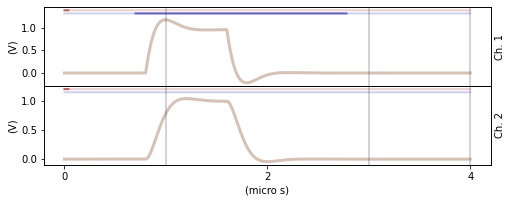

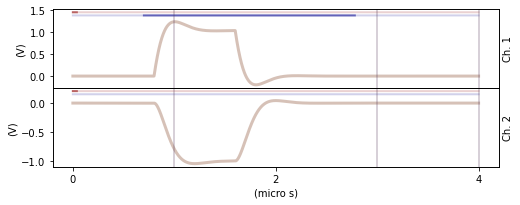

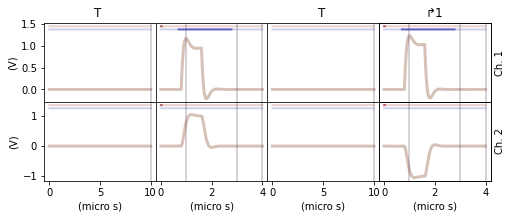

In [66]:
#all in one box,
wait_time = 1e-6
rearm_time = 10e-6
pulse_dur = 2e-6
buffer = 300e-9

#make element just for waiting for the trigger vefore each pulse
bpTrigWait = bb.BluePrint()
bpTrigWait.insertSegment(1, 'waituntil', rearm_time)
bpTrigWait.setSR(1e9)

#make the I channel for -detuning:
I0_channel = Ifunc_corrected # args: ampl, filepath_to_cavity_sim
bpI0 = bb.BluePrint()
bpI0.setSR(1e9)
bpI0.insertSegment(1, 'waituntil', (wait_time))
bpI0.insertSegment(2, I0_channel, (1, sim_filepath1), name='Ig', dur=pulse_dur)
bpI0.insertSegment(3, 'waituntil', (2*wait_time+pulse_dur))
bpI0.marker1 = [(0e-6,50e-9)]

bpI0.marker2 = [(wait_time-buffer,pulse_dur+2*buffer)]


#make the Q channel for -detuning:
Q0_channel = Qfunc_corrected # args: ampl,filepath_to_cavity_sim
bpQ0 = bb.BluePrint()
bpQ0.setSR(1e9)
bpQ0.insertSegment(1, 'waituntil', (wait_time))
bpQ0.insertSegment(2, Q0_channel, (1, sim_filepath1), name='Qg', dur=pulse_dur)
bpQ0.insertSegment(3, 'waituntil', (2*wait_time+pulse_dur))
bpQ0.marker1 = [(0e-6,50e-9)]

#make the I channel for +detuning:
I1_channel = Ifunc_corrected # args: ampl, filepath_to_cavity_sim
bpI1 = bb.BluePrint()
bpI1.setSR(1e9)
bpI1.insertSegment(1, 'waituntil', (wait_time))
bpI1.insertSegment(2, I1_channel, (1, sim_filepath2), name='Ie', dur=pulse_dur)
bpI1.insertSegment(3, 'waituntil', (2*wait_time+pulse_dur))
bpI1.marker1 = [(0e-6,50e-9)]


bpI1.marker2 = [(wait_time-buffer,pulse_dur+2*buffer)]


#make the Q channel for +detuning:
Q1_channel = Qfunc_corrected # args: ampl,filepath_to_cavity_sim
bpQ1 = bb.BluePrint()
bpQ1.setSR(1e9)
bpQ1.insertSegment(1, 'waituntil', (wait_time))
bpQ1.insertSegment(2, Q1_channel, (1, sim_filepath2), name='Qe', dur=pulse_dur)
bpQ1.insertSegment(3, 'waituntil', (2*wait_time+pulse_dur))
bpQ1.marker1 = [(0e-6,50e-9)]

##############################################
#put blueprints into elements
waitEl = bb.Element()
waitEl.addBluePrint(1, bpTrigWait)
waitEl.addBluePrint(2, bpTrigWait)

CavEl1 = bb.Element()
CavEl1.addBluePrint(1,bpI0)
CavEl1.addBluePrint(2,bpQ0)
plotter(CavEl1)

CavEl2 = bb.Element()
CavEl2.addBluePrint(1,bpI1)
CavEl2.addBluePrint(2,bpQ1)
plotter(CavEl2)

###############################################
#put elements into sequence
CavSeq = bb.Sequence()

#good values to kill leakage: 
CavSeq.setChannelAmplitude(1, 3)  # Call signature: channel, amplitude (peak-to-peak)
CavSeq.setChannelOffset(1, 0)
CavSeq.setChannelAmplitude(2, 3)
CavSeq.setChannelOffset(2, 0)

#now we have to prep it for the AWG
CavSeq.addElement(1, waitEl)
CavSeq.addElement(2, CavEl1)
CavSeq.addElement(3, waitEl)
CavSeq.addElement(4, CavEl2)

CavSeq.setSR(1e9)

#set the sequencing
# Here we repeat each element twice and then proceed to the next, wrapping over at the end
CavSeq.setSequencingTriggerWait(1, 1)
CavSeq.setSequencingTriggerWait(2, 0)
CavSeq.setSequencingTriggerWait(3, 1)
CavSeq.setSequencingTriggerWait(4, 0)
CavSeq.setSequencingGoto(4, 1)



CavSeq.checkConsistency()
plotter(CavSeq)

In [67]:
#upload to AWG
package = CavSeq.outputForAWGFile()
chan1_awg_input = package[0]
chan2_awg_input = package[1]
package.channels
awg.make_send_and_load_awg_file(*package[:])
awg.ch1_amp(1)
awg.ch2_amp(1)
awg.ch1_offset(DC_offsets[0])
awg.ch2_offset(DC_offsets[1])